In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
from scipy import stats, integrate
import os

In [2]:
import time
t0 = time.perf_counter()

# Global parameters

In [3]:
detect = ['index', 'DAQ', ''] 
detect[2] = 'SiPM' # SiPM
# detect[2] = 'PMT' # PMT

ch = 2
# n_gauss = 2

LED = [' without much LED light (1pe)', ' with a lot of LED light (signal)']

baseline_corrected = True
# baseline_corrected = False

# integr_method = 'integrate around the peak'
integr_method = 'integrate in a fixed window t1-t2'  
# integr_method = 'integrate ALL waveform'

# Data

In [4]:
filename = ['', '']

path = '/home/investigator/mariandbt/python/data/'
path = path + '20230306/'

if detect[2] == 'PMT':
    filename[0] = os.path.join(path, 'calibration_dig2-192.168.0.254-10.txt') # W/O LED
    filename[1] = os.path.join(path, 'fibers_dig2-192.168.0.254-08.txt') # WITH LED

if detect[2] == 'SiPM':
    filename[0] = os.path.join(path, 'sipm_single_photon_dig2-192.168.0.254-01.txt') # pe
    filename[1] = os.path.join(path, 'sipm_lot_of_light_dig2-192.168.0.254-07.txt') # signal


# Functions

In [5]:
# Fitting distributions to define

# note: pdf are normilized to 1 so we have yo add an amplitude param
def gauss(x, a,  mu, sigma):
    return a*stats.norm.pdf(x, mu, sigma) 

def gauss_sum2(x, a0,  mu0, sigma0, a1, mu1, sigma1):
    return a0*stats.norm.pdf(x, mu0, sigma0)  + a1*stats.norm.pdf(x, mu1, sigma1)

def gauss_sum3(x, a0,  mu0, sigma0, a1, mu1, sigma1, a2, mu2, sigma2):
    return gauss_sum2(x, a0,  mu0, sigma0, a1, mu1, sigma1)  + a2*stats.norm.pdf(x, mu2, sigma2)

def gauss_sum4(x, a0,  mu0, sigma0, a1, mu1, sigma1, a2, mu2, sigma2, a3, mu3, sigma3):
    return gauss_sum3(x, a0,  mu0, sigma0, a1, mu1, sigma1, a2, mu2, sigma2) + a3*stats.norm.pdf(x, mu3, sigma3)

def gauss_sum5(x, a0,  mu0, sigma0, a1, mu1, sigma1, a2, mu2, sigma2, a3, mu3, sigma3, a4, mu4, sigma4):
    return gauss_sum4(x, a0,  mu0, sigma0, a1, mu1, sigma1, 
                      a2, mu2, sigma2, a3, mu3, sigma3) + a4*stats.norm.pdf(x, mu4, sigma4)


# Signal waveform

### Data

In [6]:
data = []
time_bin = -1.
with open(filename[1],'r', encoding='ascii') as fp:
    for i, line in enumerate(fp):
        if (time_bin < 0.) & (any(c == '=' for c in line)):
            print('Time bin = ', line.split(' = ')[:][1])
            time_bin = float(line.split(' = ')[:][1].split(' ')[0])
        if any(c.isalpha() for c in line) == False:
            data.append(np.asarray(line.split('\t')[:-1], dtype=float))
fp.close()

waveform = np.array(data)


n_points = int(waveform[:, 0].max() + 1)
n_frames = int(len(waveform)/n_points) 

# waveform[:, 0] = waveform[:, 0]*time_bin


Time bin =  0.008 us



### RAW Waveform

In [7]:
frame_ref = int(n_frames/2); 
# frame_ref = 222; 
#     frame_ref = n_frames - 1; 
#     frame_ref = 1; 

frame = frame_ref;
# print('frame = ', frame)

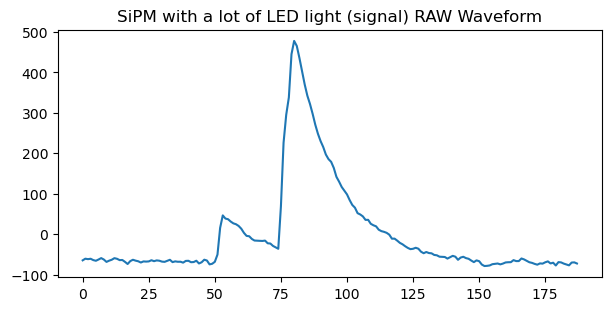

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3), constrained_layout=True)

wave = waveform[frame*n_points: (frame + 1)*n_points].copy()
x_ax = wave[:, 0]

#_________plot_settings_________________________________________________
ax.plot(x_ax, wave[:, ch], label = detect[ch])
ax.set_title(detect[ch] + LED[1] + ' RAW Waveform');

### t1 and t2 determination

In [9]:
# t1 = 0
# t2 = n_points
t1 = 70
t2 = 125

In [10]:
t2*time_bin

1.0

### Change x_axis to time units

In [11]:
waveform[:, 0] = waveform[:, 0]*time_bin

### Baseline correction 1 frame

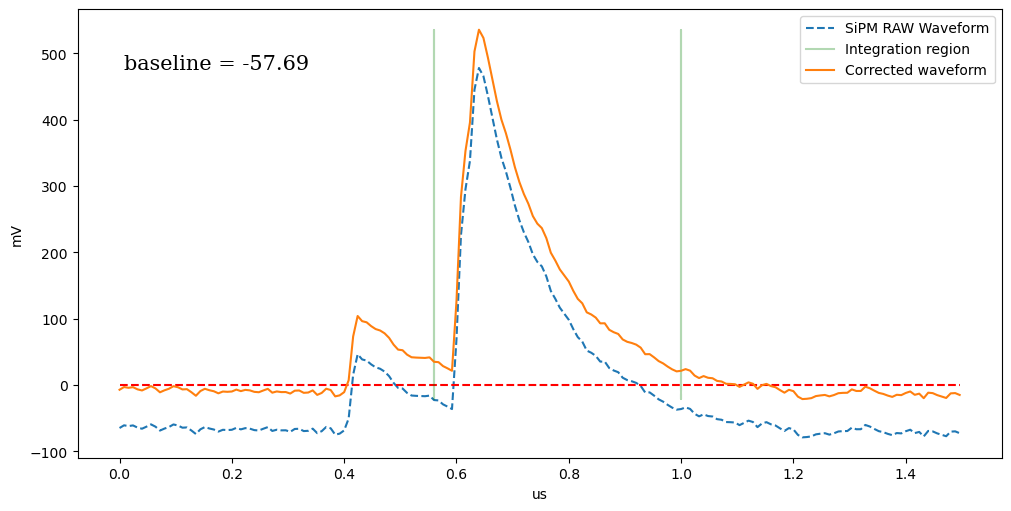

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), constrained_layout=True)

wave = waveform[frame*n_points: (frame + 1)*n_points].copy()
x_ax = wave[:, 0]

# t0 = t1 + int(np.where(wave[:, ch][t1 : t2] == wave[:, ch][t1 : t2].min())[0][0])
t0 = t1 + int(np.where(wave[:, ch][t1 : t2] == wave[:, ch][t1 : t2].max())[0][0])

# substracting the signal_______________________________________
# pre_base = wave[:, ch][:t0 - dt_izq].copy()
# x_ax_pre = x_ax[:t0 - dt_izq].copy()

# post_base = wave[:, ch][t0 + dt_dch:].copy()
# x_ax_post = x_ax[t0 + dt_dch:].copy()

# base = []
# base.append(pre_base.mean())
# base.append(post_base.mean())

# using a mask_______________________________________________
threshold = 0.
mask = wave[:, ch] < threshold
base = wave[:, ch][mask]

baseline = np.array(base).mean() 

ax.plot(x_ax, wave[:, ch], '--', label = detect[ch] + ' RAW Waveform')

wave[:, ch] = wave[:, ch] - baseline # NOW THE WAVEFORM IS CORRECTED

ax.plot(x_ax, 0*np.ones(len(x_ax)), '--r')
ax.plot(t1*time_bin*np.ones(len(x_ax)), wave[:, ch], '-g', alpha = 0.3, label = 'Integration region') # t1 from time interval
ax.plot(t2*time_bin*np.ones(len(x_ax)), wave[:, ch], '-g', alpha = 0.3) # t2 from time interval

ax.plot(x_ax, wave[:, ch], '-', label = 'Corrected waveform')

ax.set_ylabel('mV')
ax.set_xlabel('us')

ax.legend(loc = 'best')

ax.text(0.05, .9, 'baseline = %.2f'%(baseline), transform=ax.transAxes,
        fontsize=15, verticalalignment='top', fontfamily='serif',
        bbox=dict(facecolor='1.', edgecolor='none', pad=3.0));

### Baseline correction and Integration for all frames

In [13]:
peak_integr = []
peak_integr_pos = []
base_safe = []

In [14]:
for frame in range(n_frames):


#_________baseline_________________________________________________

    wave = waveform[frame*n_points: (frame + 1)*n_points].copy()
    x_ax = wave[:, 0]

    t0 = t1 + int(np.where(wave[:, ch][t1 : t2] == wave[:, ch][t1 : t2].max())[0][0])

# using a mask_____________________
    threshold = 0.
    mask = wave[:, ch] < threshold
    base = wave[:, ch][mask]

    baseline = np.array(base).mean() 
    base_safe.append(baseline)

    if baseline_corrected:
        wave[:, ch] = wave[:, ch] - baseline # NOW THE WAVEFORM IS CORRECTED

#_________integration_________________________________________________


    if integr_method == 'integrate around the peak':
        peak = wave[:, ch][t0 - dt_izq : t0 + dt_dch].copy()
        x_ax_peak = x_ax[t0 - dt_izq : t0 + dt_dch].copy()

#         control_peak = wave[:, control_ch][t0 - dt_izq : t0 + dt_dch].copy()


    if integr_method == 'integrate in a fixed window t1-t2':  
        peak = wave[:, ch][t1 : t2].copy()
        x_ax_peak = x_ax[t1 : t2].copy()

#         control_peak = wave[:, control_ch][t1 : t2].copy()


    if integr_method == 'integrate ALL waveform':
        peak = wave[:, ch].copy()
        x_ax_peak = x_ax.copy()

#         control_peak = wave[:, control_ch].copy()



    integr = np.trapz(peak, x=x_ax_peak)
#     control_integr = np.trapz(control_peak, x=x_ax_peak)

#     peak_integr.append(integr/control_integr) # normalized to the control PMT
    peak_integr.append(integr) 
    peak_integr_pos.append([integr, frame])

#     print(frame)

In [15]:
peak_integr = np.array(peak_integr)
peak_integr_pos = np.array(peak_integr_pos)
base_safe = np.array(base_safe)
print('Baseline mean = ', base_safe.mean())

Baseline mean =  -63.61423865071563


### Integral distribution

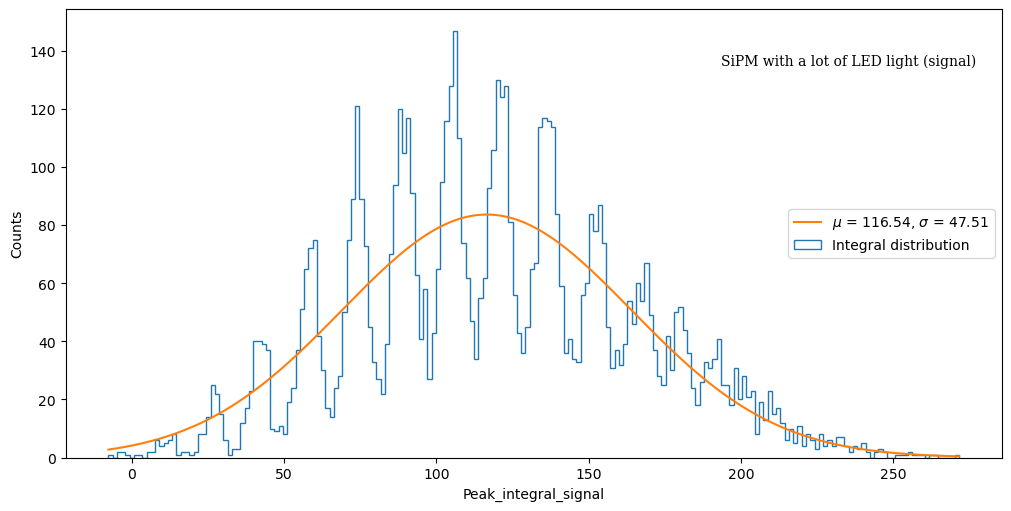

In [16]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), constrained_layout=True)

events, bins, bars = ax.hist(peak_integr, 200, density=False, label='Integral distribution', 
                              histtype='step')
x_ax = np.linspace(bins.min(), bins.max(), len(bins)-1)

# gaussian fit

# popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, bounds=([0, 0, 1], [np.inf, 3e3, 1e2])) 
popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, bins.mean(), 1e2]) 

a, mu, sigma = popt
best_fit_line = gauss(x_ax, a, mu, sigma)


#_________plot_settings_________________________________________________

ax.plot(x_ax, gauss(x_ax, a, mu, sigma), '-', label='$\mu$ = %.2f, $\sigma$ = %.2f'%(mu, sigma))

ax.set_ylabel('Counts')
ax.set_xlabel('Peak_integral_signal')

ax.text(0.7, .9, detect[ch] + LED[1], transform=ax.transAxes,
            fontsize=10, verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='1.', edgecolor='none', pad=3.0));

ax.legend(fontsize=10, loc='right')


# 1pe waveform

### Data

In [17]:
data = []
time_bin = -1.
with open(filename[0],'r', encoding='ascii') as fp:
    for i, line in enumerate(fp):
        if (time_bin < 0.) & (any(c == '=' for c in line)):
            print('Time bin = ', line.split(' = ')[:][1])
            time_bin = float(line.split(' = ')[:][1].split(' ')[0])
        if any(c.isalpha() for c in line) == False:
            data.append(np.asarray(line.split('\t')[:-1], dtype=float))
fp.close()

waveform = np.array(data)


n_points = int(waveform[:, 0].max() + 1)
n_frames = int(len(waveform)/n_points) 

Time bin =  0.008 us



### RAW Waveform

In [37]:
frame = frame_ref;
frame = 700;
# print('frame = ', frame)

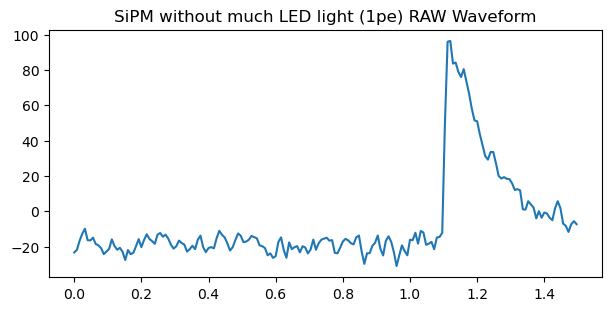

In [38]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,3), constrained_layout=True)

wave = waveform[frame*n_points: (frame + 1)*n_points].copy()
x_ax = wave[:, 0]

#_________plot_settings_________________________________________________
ax.plot(x_ax, wave[:, ch], label = detect[ch])
ax.set_title(detect[ch] + LED[0] + ' RAW Waveform');

###  Now t1 and t2 are fixed from the SIGNAL WAVEFORM !!

### Change x_axis to time units

In [20]:
waveform[:, 0] = waveform[:, 0]*time_bin

### Baseline correction 1 frame

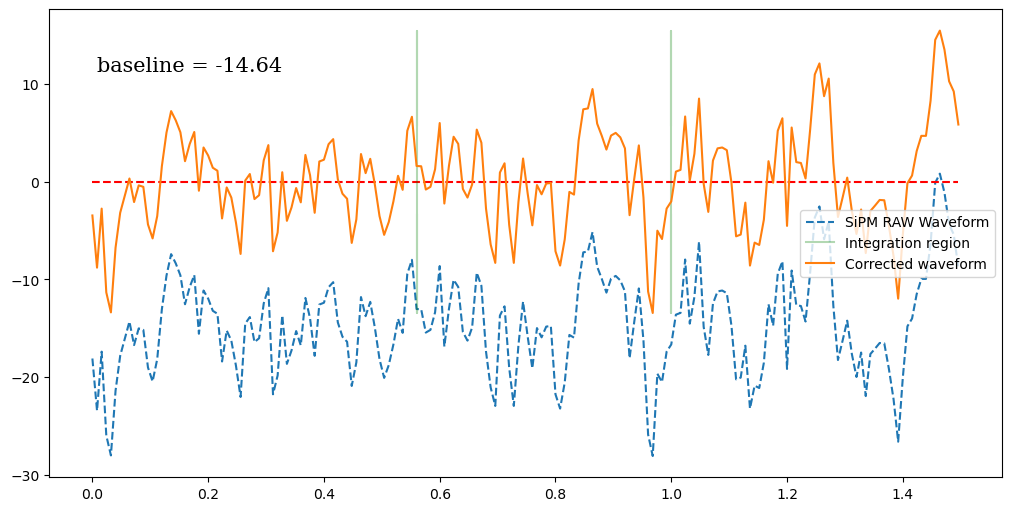

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), constrained_layout=True)

wave = waveform[frame*n_points: (frame + 1)*n_points].copy()
x_ax = wave[:, 0]

# t0 = t1 + int(np.where(wave[:, ch][t1 : t2] == wave[:, ch][t1 : t2].min())[0][0])
t0 = t1 + int(np.where(wave[:, ch][t1 : t2] == wave[:, ch][t1 : t2].max())[0][0])

# substracting the signal_______________________________________
# pre_base = wave[:, ch][:t0 - dt_izq].copy()
# x_ax_pre = x_ax[:t0 - dt_izq].copy()

# post_base = wave[:, ch][t0 + dt_dch:].copy()
# x_ax_post = x_ax[t0 + dt_dch:].copy()

# base = []
# base.append(pre_base.mean())
# base.append(post_base.mean())

# using a mask_______________________________________________
threshold = 0.
mask = wave[:, ch] < threshold
base = wave[:, ch][mask]

baseline = np.array(base).mean() 

ax.plot(x_ax, wave[:, ch], '--', label = detect[ch] + ' RAW Waveform')

wave[:, ch] = wave[:, ch] - baseline # NOW THE WAVEFORM IS CORRECTED

ax.plot(x_ax, 0*np.ones(len(x_ax)), '--r')
ax.plot(t1*time_bin*np.ones(len(x_ax)), wave[:, ch], '-g', alpha = 0.3, label = 'Integration region') # t1 from time interval
ax.plot(t2*time_bin*np.ones(len(x_ax)), wave[:, ch], '-g', alpha = 0.3) # t2 from time interval

ax.plot(x_ax, wave[:, ch], '-', label = 'Corrected waveform')

ax.legend(loc = 'right')

ax.text(0.05, .9, 'baseline = %.2f'%(baseline), transform=ax.transAxes,
        fontsize=15, verticalalignment='top', fontfamily='serif',
        bbox=dict(facecolor='1.', edgecolor='none', pad=3.0));

### Baseline correction and Integration for all frames

In [22]:
peak_integr = []
peak_integr_pos = []
base_safe = []

In [23]:
for frame in range(n_frames):


#_________baseline_________________________________________________

    wave = waveform[frame*n_points: (frame + 1)*n_points].copy()
    x_ax = wave[:, 0]

    t0 = t1 + int(np.where(wave[:, ch][t1 : t2] == wave[:, ch][t1 : t2].max())[0][0])

# using a mask_____________________
    threshold = 0.
    mask = wave[:, ch] < threshold
    base = wave[:, ch][mask]

    baseline = np.array(base).mean() 
    base_safe.append(baseline)

    if baseline_corrected:
        wave[:, ch] = wave[:, ch] - baseline # NOW THE WAVEFORM IS CORRECTED

#_________integration_________________________________________________


    if integr_method == 'integrate around the peak':
        peak = wave[:, ch][t0 - dt_izq : t0 + dt_dch].copy()
        x_ax_peak = x_ax[t0 - dt_izq : t0 + dt_dch].copy()

#         control_peak = wave[:, control_ch][t0 - dt_izq : t0 + dt_dch].copy()


    if integr_method == 'integrate in a fixed window t1-t2':  
        peak = wave[:, ch][t1 : t2].copy()
        x_ax_peak = x_ax[t1 : t2].copy()

#         control_peak = wave[:, control_ch][t1 : t2].copy()


    if integr_method == 'integrate ALL waveform':
        peak = wave[:, ch].copy()
        x_ax_peak = x_ax.copy()

#         control_peak = wave[:, control_ch].copy()



    integr = np.trapz(peak, x=x_ax_peak)
#     control_integr = np.trapz(control_peak, x=x_ax_peak)

#     peak_integr.append(integr/control_integr) # normalized to the control PMT
    peak_integr.append(integr) 
    peak_integr_pos.append([integr, frame])

#     print(frame)

In [24]:
peak_integr = np.array(peak_integr)
peak_integr_pos = np.array(peak_integr_pos)
base_safe = np.array(base_safe)
print('Baseline mean = %.2f'%(base_safe.mean()))

Baseline mean = -17.69


### Integral distribution

In [25]:
n_gauss = 4

1581.068142625106
474.650956462387
407.5304829635146
1128.2039807925846


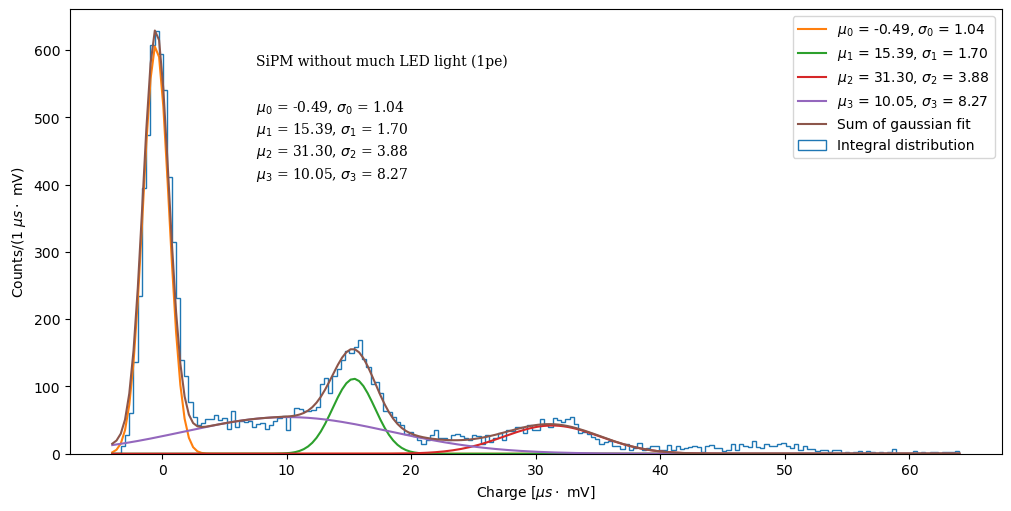

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,5), constrained_layout=True)

events, bins, bars = ax.hist(peak_integr, 200, density=False, range=(-5e2*time_bin, 0.8e4*time_bin), label='Integral distribution', 
                              histtype='step')
x_ax = np.linspace(bins.min(), bins.max(), len(bins)-1)

if n_gauss == 1:
# gaussian fit

    # popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, bounds=([0, 0, 1], [np.inf, 3e3, 1e2])) 
    popt, pcov = scipy.optimize.curve_fit(gauss, x_ax, events, p0=[1, bins.mean(), 1e2]) 

    a, mu, sigma = popt
    best_fit_line = gauss(x_ax, a, mu, sigma)

if n_gauss == 2:
# sum of 2 gaussians fit

#         popt, pcov = scipy.optimize.curve_fit(gauss_sum, x_ax, events, bounds=([0, -1, 1, 0, -1, 1], 
#                                                                                [np.inf, 1e2, 1e2, np.inf, 1e2, 1e2])) 

    popt, pcov = scipy.optimize.curve_fit(gauss_sum2, x_ax, events, p0=[1e3, 0., 1e2, 
                                                                        1e3, 1600, 1e2]) 
    a = np.zeros(n_gauss); mu = np.zeros(n_gauss); sigma = np.zeros(n_gauss)

    a[0], mu[0], sigma[0], a[1], mu[1], sigma[1] = popt
    best_fit_line = gauss_sum2(x_ax, a[0], mu[0], sigma[0], a[1], mu[1], sigma[1])

if n_gauss == 3:
# sum of 3 gaussians fit

    popt, pcov = scipy.optimize.curve_fit(gauss_sum3, x_ax, events, p0=[1, 0., 1e2, 
                                                                        1, 1600*time_bin, 1e2*time_bin, 
                                                                        1, 3900*time_bin, 1e2*time_bin]) 
    a = np.zeros(n_gauss); mu = np.zeros(n_gauss); sigma = np.zeros(n_gauss)

    a[0], mu[0], sigma[0], a[1], mu[1], sigma[1], a[2], mu[2], sigma[2] = popt
    best_fit_line = gauss_sum3(x_ax, a[0], mu[0], sigma[0], a[1], mu[1], sigma[1], a[2], mu[2], sigma[2])


if n_gauss == 4:
# sum of 4 gaussians fit

    popt, pcov = scipy.optimize.curve_fit(gauss_sum4, x_ax, events, p0=[1, 0., 1e2, 
                                                                        0., 2000*time_bin, 1e2*time_bin, 
                                                                        0., 4000*time_bin, 1e2*time_bin, 
#                                                                         0.05, 6000*time_bin, 1e4])
                                                                        0., 50., 1e3])

    a = np.zeros(n_gauss); mu = np.zeros(n_gauss); sigma = np.zeros(n_gauss)

    a[0], mu[0], sigma[0], a[1], mu[1], sigma[1], a[2], mu[2], sigma[2], a[3], mu[3], sigma[3] = popt
    best_fit_line = gauss_sum4(x_ax, a[0], mu[0], sigma[0], a[1], mu[1], sigma[1], 
                               a[2], mu[2], sigma[2], a[3], mu[3], sigma[3])


if n_gauss == 5:
# sum of 5 gaussians fit

    popt, pcov = scipy.optimize.curve_fit(gauss_sum5, x_ax, events, p0=[1, 0., 1e2*time_bin, 
                                                                        1, 2000*time_bin, 1e2*time_bin, 
                                                                        1, 4000*time_bin, 1e2*time_bin, 
                                                                        1, 6000*time_bin, 1e2*time_bin, 
                                                                        1, 8000*time_bin, 1e2*time_bin])

    a = np.zeros(n_gauss); mu = np.zeros(n_gauss); sigma = np.zeros(n_gauss)

    a[0], mu[0], sigma[0], a[1], mu[1], sigma[1], a[2], mu[2], sigma[2], a[3], mu[3], sigma[3], a[4], mu[4], sigma[4] = popt
    best_fit_line = gauss_sum5(x_ax, a[0], mu[0], sigma[0], a[1], mu[1], sigma[1], 
                               a[2], mu[2], sigma[2], a[3], mu[3], sigma[3], a[4], mu[4], sigma[4])



signal = np.array([mu, sigma])
signal.view('i8, '*(n_gauss -1) + 'i8').sort(order=['f1'], axis=1)

#_________plot_settings_________________________________________________

if n_gauss > 1:
    for i in range(n_gauss):
        ax.plot(x_ax, gauss(x_ax, a[i], mu[i], sigma[i]), '-', 
                label='$\mu_{%d}$ = %.2f, $\sigma_{%d}$ = %.2f'%(i, mu[i], i, sigma[i]))
        ax.text(0.2, .8 - 0.05*i, 
                '$\mu_{%d}$ = %.2f, $\sigma_{%d}$ = %.2f'%(i, signal[0, i], i, signal[1, i]), transform=ax.transAxes,
                fontsize=10, verticalalignment='top', fontfamily='serif',
                bbox=dict(facecolor='1.', edgecolor='none', pad=3.0));
        print(a[i])

    ax.plot(x_ax, best_fit_line, '-', label='Sum of gaussian fit')
    
else:
    ax.plot(x_ax, gauss(x_ax, a, mu, sigma), '-', label='$\mu$ = %.2f, $\sigma$ = %.2f'%(mu, sigma))

ax.set_ylabel('Counts/(1 $\mu s\cdot$ mV)')
ax.set_xlabel('Charge [$\mu s\cdot$ mV]')

ax.text(0.2, .9, detect[ch] + LED[0], transform=ax.transAxes,
            fontsize=10, verticalalignment='top', fontfamily='serif',
            bbox=dict(facecolor='1.', edgecolor='none', pad=3.0));

ax.legend(fontsize=10, loc='best')
# ax.legend(fontsize=10, loc='center')



# Single PE

In [27]:
print('Gaussians means:', signal)
print('Baseline corrected:', baseline_corrected)
print('Integration method:', integr_method)

Gaussians means: [[-0.49373799 15.39239958 31.30241227 10.05269787]
 [ 1.03823744  1.69935572  3.87668211  8.26626497]]
Baseline corrected: True
Integration method: integrate in a fixed window t1-t2


# Timer

In [28]:
tf = time.perf_counter()
print('Code timer: %.2f'%(tf-t0))

Code timer: 91234.41
